In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Compound pendulum with spring supports

![creating equations of motion](../images/11_conservative-lagrangian.png)

In this notebook, you will use the two coupled equations of motion to create a _linear_ solution for $\theta(t)~and~x(t)$ for a compound pendulum supported by two springs. 

After creating the Lagrangian, $L=T-V$, and setting the variation in $\delta L=0$, you arrive at 2 coupled equations of motion:

1. $\frac{mL^2}{3}\ddot{\theta}+\frac{mL}{4}\ddot{x}\cos\theta-\frac{mgL}{2}\sin\theta = 0$
2. $m\ddot{x}+\frac{mL}{4}\ddot{\theta}\cos\theta-\frac{ml^2}{4}\dot{\theta}^2+2kx = 0$

Here, you can assume $\theta<<1$ which results in three simplifications:
1. $\dot{\theta}^2\approx 0$ because if $\theta$ is small, then $\dot{\theta}$ small and squaring it is _really_ small
2. $\sin\theta \approx \theta$ the first term in a Taylor series expanding at $\theta=0$
3. $\cos\theta \approx 1$ the first term in a Taylor series expanding at $\theta=0$

Now, you can separate the equations into a linear system  as such

$\mathbf{M\ddot{q}+Kq}=\mathbf{0}$

where $\mathbf{q}=[\theta,~x]$ are the generalized coordinates for the system. The equations are now

$\left[\begin{array}
~\frac{mL^2}{3} & \frac{mL}{4} \\
\frac{mL}{4} & m\end{array}\right]
\left[\begin{array}
~\ddot{\theta} \\
\ddot{x}\end{array}\right]+
\left[\begin{array}
~\frac{mgL}{2} & 0 \\
0 & 2k \end{array}\right]\left[\begin{array}
~\theta \\
x\end{array}\right]
=0
$

In [45]:
m = 1 # kg
L = 1 # m
g = 9.81 # m/s/s
k = 20 # N/m

M = np.array([[m*L**2/3,m*L/4],[m*L/4, m]])
K = np.zeros((2,2))
K[0,0] = m*g*L/2
K[1,1] = 2*k

print('mass matrix:')
print(M)
print('stiffness matrix:')
print(K)

mass matrix:
[[0.33333333 0.25      ]
 [0.25       1.        ]]
stiffness matrix:
[[ 4.905  0.   ]
 [ 0.    40.   ]]


To create a solution, you can either 
- solve the eigenvector problem
- create the ode function and solve with `solve_ivp`

## Eigenvector solution

The system of equations can be reframed as an eigenvalue-eigenvector problem because it is a linear system
let $\mathbf{q} = \mathbf{u}e^{i\omega t}$

$(-\omega^2\mathbf{Mu+Ku})e^{i\omega t}=\mathbf{0}$

eigenvalue solutions take the [form](http://fourier.eng.hmc.edu/e161/lectures/algebra/node7.html):

$\mathbf{(-\lambda B u+Au)}=\mathbf{0}.$

### Solve for eigenvalues and eigenvectors
You can use [`scipy.linalg.eig`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eig.html) to solve for the eigenvalues and eigenvectors as such

In [46]:
from scipy.linalg import eig

e, v = eig(K,M)
w = e**0.5
print('natural frequencies are:')
print(w)
print('eigenvectors are:')
print(v)

natural frequencies are:
[3.66604064+0.j 7.34177666+0.j]
eigenvectors are:
[[-0.99209315 -0.71802945]
 [-0.12550371  0.69601272]]


### Define the solution for $\theta(t)$ and $x(t)$
The eigenvalue solution gives you the form of the equations for $\mathbf{q}(t)$ as such

$\left[\begin{array}
~\theta(t) \\
x(t)\end{array}\right] = a_1\mathbf{u_1}e^{i\omega_1 t} + 
                         a_2\mathbf{u_2}e^{i\omega_2 t} +
                         a_3\mathbf{u_1}e^{-i\omega_1 t} +
                         a_4\mathbf{u_2}e^{-i\omega_2 t}$
                         
### Plug in initial conditions and solve for integration constants
There are 4 integration constants because there are two second order differential equations that were integrated two times. You can solve for $\mathbf{a}=[a_1,~a_2,~a_3,~a_4]$ using the initial conditions as such

$\left[\begin{array}
~\mathbf{u_1} & \mathbf{u_2} & \mathbf{u_1} & \mathbf{u_2} \\
i\omega_1\mathbf{u_1} & i\omega_2\mathbf{u_2} & -i\omega_1\mathbf{u_1} & -i\omega_2\mathbf{u_2}
\end{array}\right]
\left[\begin{array}
~a_1\\
a_2\\
a_3\\
a_4\end{array}\right] =
\left[\begin{array}
~\theta(0)\\
x(0)\\
\dot{\theta}(0)\\
\dot{x}(0)\end{array}\right]$

In [47]:
q0 = np.array([np.pi/6, 0, 0, 0])
C = np.block([[v, v], [w*1j*v, -w*1j*v]])

In the above cell, you create the array with initial position and velocity as `q0` and use the array `C` to set up the system of equations using the eigenvectors and natural frequencies. 

Now, use `np.linalg.solve` to determine the constants, $\mathbf{a}=[a_1,~a_2,~a_3,~a_4]=$ `A`.

In [49]:
A = np.linalg.solve(C, q0)
A

array([-0.2334229 +0.j, -0.04209038-0.j, -0.2334229 -0.j, -0.04209038+0.j])

### Plug in integration constants and plot results

Now, you have a solution for $\theta(t)~and~x(t)$. Define your independent variable, time `t`, and plot the solution. The definitions for `theta` and `x` are based upon the eigenvalue solution defined above as such

$\left[\begin{array}
~\theta(t) \\
x(t)\end{array}\right] = a_1\mathbf{u_1}e^{i\omega_1 t} + 
                         a_2\mathbf{u_2}e^{i\omega_2 t} +
                         a_3\mathbf{u_1}e^{-i\omega_1 t} +
                         a_4\mathbf{u_2}e^{-i\omega_2 t}$

In [50]:
t = np.linspace(0,2)
theta = A[0]*v[0,0]*np.exp(1j*w[0]*t)+\
    A[1]*v[0,1]*np.exp(1j*w[1]*t)+\
    A[2]*v[0,0]*np.exp(-1j*w[0]*t)+\
    A[3]*v[0,1]*np.exp(-1j*w[1]*t)

x = A[0]*v[1,0]*np.exp(1j*w[0]*t)+\
    A[1]*v[1,1]*np.exp(1j*w[1]*t)+\
    A[2]*v[1,0]*np.exp(-1j*w[0]*t)+\
    A[3]*v[1,1]*np.exp(-1j*w[1]*t)

> __Note__: The general solutions here could include imaginary numbers since the solution is $a e^{-i\omega t}$. You can check the imaginary components of `theta` and `x` with `.imag`. You should see the maximum and minium are $<10^{-15}.$

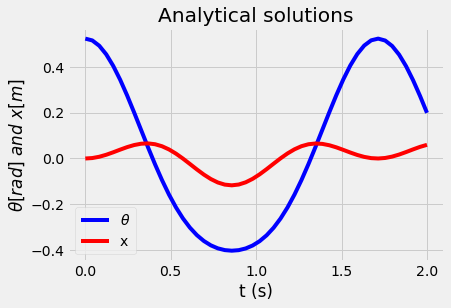

In [54]:
plt.plot(t,theta.real,'b-', label=r'$\theta$')
plt.plot(t,x.real, 'r-', label = 'x')
plt.title('Analytical solutions')
plt.ylabel(r'$\theta[rad]~and~x[m]$')
plt.xlabel('t (s)')
plt.legend();

## Numerical solution - `solve_ivp`

The advantage to solving the system using the eigenvalue method is that you have an exact solution with analytical functions. This is only possible, for most situations, for _linear systems_. For _nonlinear systems_, you have to use a numerical integration technique such as Runge-Kutta or Euler integration. The [`scipy.integrate.solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) function will create a numerical solution that is accurate for _linear_ and _nonlinear_ systems. 

First, set up a function that represents the two second-order differential equations as 4 first-order differential equations, $\dot{\mathbf{y}} = f(t,\mathbf{y})$, where $\mathbf{y}=[\theta,~x,~\dot{\theta},~\dot{x}]$

1. $\dot{y}_1 = y_3$
1. $\dot{y}_2 = y_4$
3. & 4.  $\left[\begin{array}
~\frac{mL^2}{3} & \frac{mL}{4} \\
\frac{mL}{4} & m\end{array}\right]
\left[\begin{array}
~\dot{y}_3 ~[\ddot{\theta}] \\
\dot{y}_4 ~[\ddot{x}]\end{array}\right]=
-\left[\begin{array}
~\frac{mgL}{2} & 0 \\
0 & 2k \end{array}\right]\left[\begin{array}
~\theta \\
x\end{array}\right]
$

> __Note__: Equations 3 & 4 will work with nonlinear equations too. You can define $\mathbf{M}=f(\theta,x)=\left[\begin{array}
~\frac{mL^2}{3} & \frac{mL}{4}\cos\theta \\
\frac{mL}{4}\cos\theta & m\end{array}\right]$ where $\theta=y_1$ and $x=y_2$. You can also use $-\mathbf{Kq}=-\left[\frac{mgL}{2}\sin\theta,~2kx-\frac{ml^2}{4}\dot{\theta}^2\right]$ for the nonlinear stiffness component. 

### Set up first-order differential equations

Below, you set up the 4 differential equations in the function, `couple_ode`

In [55]:
def couple_ode(t, y):
    '''
    couple_ode(t, y) calculates the derivative of the state variable y 
    based upon the current time, t, and current state, 
    y = [theta, x, dtheta/dt, dx/dt]
    
    It is assumed that M and K were previously defined. If you update the mass
    and stiffness arrays, you must rerun this function to update the ode
    
    Parameters
    ----------
    t : current time
    y : current state variable [theta, x, dtheta/dt, dx/dt]
    Returns
    -------
    dy : the derivative of y [dtheta/dt, dx/dt, ddtheta, ddx] calculated with M and K arrays
    
    '''
    dy = np.zeros(y.shape)
    dy[0] = y[2]
    dy[1] = y[3]
    dy[2:4] = np.linalg.solve(M,-K@y[0:2])
    return dy

### Solve initial value problem

The differential equations now exist as function defined in Python. You can test the function by running `couple_ode(t, q)` (as seen below, try some other value for $\theta~and~x$). 

Now, you can input initial conditions and time period to create a numerical solution with `solve_ivp(ode_function, [start-time, end-time], [y1(0), y2(0), y3(0), y4(0)])`

In [57]:
couple_ode(0, np.array([0.1,0,0,0]))

array([ 0.        ,  0.        , -1.81107692,  0.45276923])

In [59]:
from scipy.integrate import solve_ivp

q0 = np.array([np.pi/6,0,0,0]) # initial conditions copied from above
sol = solve_ivp(couple_ode, [0,2], q0, t_eval = t)

### Compare analytical and numerical solutions

Next, you can compare your analytical solution to your numerical solution. In this case, you should expect that the numerical solution will converge to the analytical solution. The analytical is the exact solution based upon the defined linear system. 

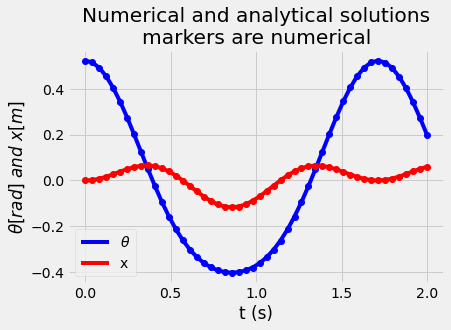

In [60]:
plt.plot(t,theta.real,'b-', label=r'$\theta$')
plt.plot(t,x.real, 'r-', label = 'x')
plt.plot(sol.t, sol.y[0], 'bo')
plt.plot(sol.t, sol.y[1], 'ro')
plt.title('Numerical and analytical solutions\nmarkers are numerical')
plt.ylabel(r'$\theta[rad]~and~x[m]$')
plt.xlabel('t (s)')
plt.legend();

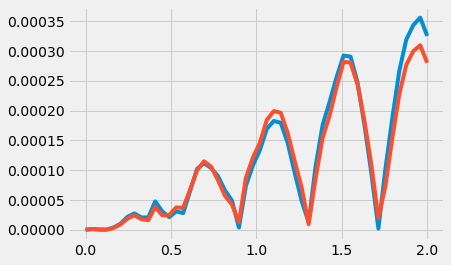

In [61]:
plt.plot(t, np.abs(sol.y[0]-theta.real))
plt.plot(t, np.abs(sol.y[1]-x.real))

## Wrapping up

In this notebook, you solved a set of coupled second order differential equations using 2 methods:
1. exact solution with eigenvalues and initial conditions
2. approximate solution with `solve_ivp` and initial conditions

You compared the results by plotting the solutions. 